This notebook performs the same analysis as performed in CalibrationV3.ipynb. However, here it is performed on the PXD032235 subset mzML file which reveals a non-linear m/z error over RT relationship. Hence, this provides the impetus to look further into non-linear regression techniques for calibration.

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
tsv_file_path = '20210120_HM_HEK_IAA_300minGr_R1.tsv'
df = pd.read_csv(tsv_file_path, sep='\t')
df.head(5)

,peptide,proteins,num_proteins,filename,scannr,rank,label,expmass,calcmass,charge,peptide_len,missed_cleavages,isotope_error,precursor_ppm,fragment_ppm,hyperscore,delta_next,delta_best,rt,aligned_rt,predicted_rt,delta_rt_model,matched_peaks,longest_b,longest_y,longest_y_pct,matched_intensity_pct,scored_candidates,poisson,sage_discriminant_score,posterior_error,spectrum_q,peptide_q,protein_q,ms1_intensity,ms2_intensity
0,VSHVSTGGGASLELLEGK,tr|A0A140VJR3|A0A140VJR3_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=20762,1,1,1739.9047,1739.9056,2,18,0,0.0,0.561273,4.512378,80.898759,57.306250,0.0,106.39572,0.358235,0.444003,0.085768,28,7,15,0.833333,52.370990,27,-22.036961,3.051130,-324.0,0.000159,0.000292,0.001187,17372374.0,2015707.5
1,HIADLAGNSEVILPVPAFNVINGGSHAGNK,tr|A0A2R8YEM5|A0A2R8YEM5_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=59286,1,1,3010.5667,3010.5623,4,30,0,0.0,1.459703,3.733232,91.211309,91.211309,0.0,206.77390,0.696208,0.741128,0.044919,29,12,17,0.566667,55.617220,23,-21.322521,2.981234,-324.0,0.000159,0.000292,0.001187,432567550.0,83529656.0
2,HIADLAGNSEVILPVPAFNVINGGSHAGNK,tr|A0A2R8YEM5|A0A2R8YEM5_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=59470,1,1,3010.5623,3010.5623,4,30,0,0.0,0.000000,3.123588,87.483751,87.483751,0.0,207.29668,0.697969,0.741128,0.043159,29,12,17,0.566667,48.368570,11,-16.460864,2.966786,-324.0,0.000159,0.000292,0.001187,95504160.0,13040154.0
3,SADESGQALLAAGHYASDEVR,tr|A0A0D9SF54|A0A0D9SF54_HUMAN;tr|A0A0D9SFF6|A...,4,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=29517,1,1,2145.9910,2145.9927,2,21,0,0.0,0.796361,4.024200,81.779226,63.839595,0.0,128.34155,0.432126,0.390783,0.041344,29,11,14,0.666667,51.264275,10,-16.229365,2.950630,-324.0,0.000159,0.000292,0.001187,8474093.0,1180256.4
4,DLSAAGIGLLAAATQSLSMPASLGR,tr|A0A0R4J2E8|A0A0R4J2E8_HUMAN;tr|A0A1B0GX04|A...,2,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=87181,1,1,2370.2590,2370.2576,2,25,0,0.0,0.618010,4.127809,84.998809,54.519394,0.0,292.91214,0.986236,0.972109,0.014127,28,13,15,0.600000,59.573494,45,-22.521459,2.929744,-324.0,0.000163,0.000299,0.000913,47365012.0,22585296.0


In [4]:
dimensions = df.shape
print(dimensions)

(60108, 36)


In [5]:
df2 = df[df["spectrum_q"] < 0.01]
dimensions2 = df2.shape
print(dimensions2)
df2.head(5)

(46806, 36)


,peptide,proteins,num_proteins,filename,scannr,rank,label,expmass,calcmass,charge,peptide_len,missed_cleavages,isotope_error,precursor_ppm,fragment_ppm,hyperscore,delta_next,delta_best,rt,aligned_rt,predicted_rt,delta_rt_model,matched_peaks,longest_b,longest_y,longest_y_pct,matched_intensity_pct,scored_candidates,poisson,sage_discriminant_score,posterior_error,spectrum_q,peptide_q,protein_q,ms1_intensity,ms2_intensity
0,VSHVSTGGGASLELLEGK,tr|A0A140VJR3|A0A140VJR3_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=20762,1,1,1739.9047,1739.9056,2,18,0,0.0,0.561273,4.512378,80.898759,57.306250,0.0,106.39572,0.358235,0.444003,0.085768,28,7,15,0.833333,52.370990,27,-22.036961,3.051130,-324.0,0.000159,0.000292,0.001187,17372374.0,2015707.5
1,HIADLAGNSEVILPVPAFNVINGGSHAGNK,tr|A0A2R8YEM5|A0A2R8YEM5_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=59286,1,1,3010.5667,3010.5623,4,30,0,0.0,1.459703,3.733232,91.211309,91.211309,0.0,206.77390,0.696208,0.741128,0.044919,29,12,17,0.566667,55.617220,23,-21.322521,2.981234,-324.0,0.000159,0.000292,0.001187,432567550.0,83529656.0
2,HIADLAGNSEVILPVPAFNVINGGSHAGNK,tr|A0A2R8YEM5|A0A2R8YEM5_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=59470,1,1,3010.5623,3010.5623,4,30,0,0.0,0.000000,3.123588,87.483751,87.483751,0.0,207.29668,0.697969,0.741128,0.043159,29,12,17,0.566667,48.368570,11,-16.460864,2.966786,-324.0,0.000159,0.000292,0.001187,95504160.0,13040154.0
3,SADESGQALLAAGHYASDEVR,tr|A0A0D9SF54|A0A0D9SF54_HUMAN;tr|A0A0D9SFF6|A...,4,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=29517,1,1,2145.9910,2145.9927,2,21,0,0.0,0.796361,4.024200,81.779226,63.839595,0.0,128.34155,0.432126,0.390783,0.041344,29,11,14,0.666667,51.264275,10,-16.229365,2.950630,-324.0,0.000159,0.000292,0.001187,8474093.0,1180256.4
4,DLSAAGIGLLAAATQSLSMPASLGR,tr|A0A0R4J2E8|A0A0R4J2E8_HUMAN;tr|A0A1B0GX04|A...,2,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=87181,1,1,2370.2590,2370.2576,2,25,0,0.0,0.618010,4.127809,84.998809,54.519394,0.0,292.91214,0.986236,0.972109,0.014127,28,13,15,0.600000,59.573494,45,-22.521459,2.929744,-324.0,0.000163,0.000299,0.000913,47365012.0,22585296.0


In [6]:
df2['exp_m/z'] = df2['expmass'] / df2['charge']
df2['calc_m/z'] = df2['calcmass'] / df2['charge']
df2['m/z_difference'] = df2['calc_m/z'] - df2['exp_m/z']
df2.head(10)

/tmp/ipykernel_165415/3373817243.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['exp_m/z'] = df2['expmass'] / df2['charge']
/tmp/ipykernel_165415/3373817243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['calc_m/z'] = df2['calcmass'] / df2['charge']
/tmp/ipykernel_165415/3373817243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,peptide,proteins,num_proteins,filename,scannr,rank,label,expmass,calcmass,charge,peptide_len,missed_cleavages,isotope_error,precursor_ppm,fragment_ppm,hyperscore,delta_next,delta_best,rt,aligned_rt,predicted_rt,delta_rt_model,matched_peaks,longest_b,longest_y,longest_y_pct,matched_intensity_pct,scored_candidates,poisson,sage_discriminant_score,posterior_error,spectrum_q,peptide_q,protein_q,ms1_intensity,ms2_intensity,exp_m/z,calc_m/z,m/z_difference
0,VSHVSTGGGASLELLEGK,tr|A0A140VJR3|A0A140VJR3_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=20762,1,1,1739.9047,1739.9056,2,18,0,0.0,0.561273,4.512378,80.898759,57.306250,0.0,106.39572,0.358235,0.444003,0.085768,28,7,15,0.833333,52.370990,27,-22.036961,3.051130,-324.0,0.000159,0.000292,0.001187,17372374.0,2015707.5,869.952350,869.952800,0.000450
1,HIADLAGNSEVILPVPAFNVINGGSHAGNK,tr|A0A2R8YEM5|A0A2R8YEM5_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=59286,1,1,3010.5667,3010.5623,4,30,0,0.0,1.459703,3.733232,91.211309,91.211309,0.0,206.77390,0.696208,0.741128,0.044919,29,12,17,0.566667,55.617220,23,-21.322521,2.981234,-324.0,0.000159,0.000292,0.001187,432567550.0,83529656.0,752.641675,752.640575,-0.001100
2,HIADLAGNSEVILPVPAFNVINGGSHAGNK,tr|A0A2R8YEM5|A0A2R8YEM5_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=59470,1,1,3010.5623,3010.5623,4,30,0,0.0,0.000000,3.123588,87.483751,87.483751,0.0,207.29668,0.697969,0.741128,0.043159,29,12,17,0.566667,48.368570,11,-16.460864,2.966786,-324.0,0.000159,0.000292,0.001187,95504160.0,13040154.0,752.640575,752.640575,0.000000
3,SADESGQALLAAGHYASDEVR,tr|A0A0D9SF54|A0A0D9SF54_HUMAN;tr|A0A0D9SFF6|A...,4,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=29517,1,1,2145.9910,2145.9927,2,21,0,0.0,0.796361,4.024200,81.779226,63.839595,0.0,128.34155,0.432126,0.390783,0.041344,29,11,14,0.666667,51.264275,10,-16.229365,2.950630,-324.0,0.000159,0.000292,0.001187,8474093.0,1180256.4,1072.995500,1072.996350,0.000850
4,DLSAAGIGLLAAATQSLSMPASLGR,tr|A0A0R4J2E8|A0A0R4J2E8_HUMAN;tr|A0A1B0GX04|A...,2,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=87181,1,1,2370.2590,2370.2576,2,25,0,0.0,0.618010,4.127809,84.998809,54.519394,0.0,292.91214,0.986236,0.972109,0.014127,28,13,15,0.600000,59.573494,45,-22.521459,2.929744,-324.0,0.000163,0.000299,0.000913,47365012.0,22585296.0,1185.129500,1185.128800,-0.000700
5,AVGTPGGGGGGAVPGISAMSR,tr|A0A1U9X972|A0A1U9X972_HUMAN;tr|A0A1U9X975|A...,13,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=25185,1,1,1754.8650,1754.8734,2,21,0,0.0,4.799704,4.781833,73.180405,48.354785,0.0,117.48154,0.395561,0.350517,0.045044,25,4,18,0.857143,46.053066,38,-20.648461,2.919695,-324.0,0.000163,0.000299,0.000913,5999690.5,1317548.8,877.432500,877.436700,0.004200
6,TNLYQDDAVTGEAAGLALGLVMLGSK,tr|A0A7I2V262|A0A7I2V262_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=86290,1,1,2606.3270,2606.3262,3,26,0,0.0,0.281017,4.128405,82.745580,82.745580,0.0,290.72565,0.978874,1.000000,0.021126,28,15,13,0.500000,47.424170,26,-21.227339,2.895146,-324.0,0.000159,0.000292,0.001187,6939569.5,5874568.0,868.775667,868.775400,-0.000267
7,KGADSLEDFLYHEGYAC[+57.0214]TSIHGDR,tr|A0A0J9YVQ7|A0A0J9YVQ7_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=38786,1,1,2740.2188,2740.2188,3,24,1,0.0,0.000000,4.342147,77.265699,77.265699,0.0,151.94298,0.511593,0.417791,0.093801,27,6,15,0.625000,51.125770,19,-21.210374,2.881736,-324.0,0.000163,0.000299,0.000913,13877569.0,1224927.0,913.406267,913.406267,0.000000
8,GLVAVITGGASGLGLATAER,tr|A0A0S2Z410|A0A0S2Z410_HUMAN;tr|A0A0S2Z434|A...,2,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=59845,1,1,1812.0140,1812.0106,2,20,0,0.0,1.886283,5.112236,74.676914,46.203998,0.0,208.32321,0.701425,0.703422,0.001997,25,7,16,0.800000,58.276936,20,-16.643

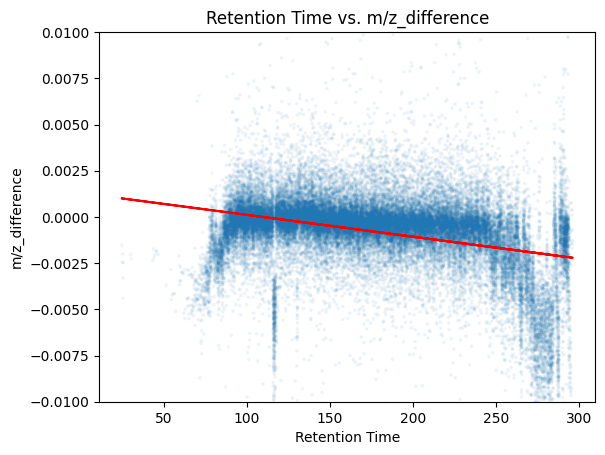

Slope: -1.1812981416629081e-05
Intercept: 0.001291879168543407


In [7]:
import matplotlib.pyplot as plt
import numpy as np
# Scatter plot
plt.scatter(df2['rt'], df2['m/z_difference'], marker='o', linestyle='', alpha=0.05, s=3)
plt.xlabel('Retention Time')
plt.ylabel('m/z_difference')
plt.title('Retention Time vs. m/z_difference')
plt.ylim(-0.01,0.01)

# Fit a line
x = df2['rt']
y = df2['m/z_difference']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
plt.plot(x, polynomial(x), color='red')

plt.show()

# Get the coefficients
slope, intercept = coefficients
print("Slope:", slope)
print("Intercept:", intercept)

In [8]:
df2['adjusted_m/z_difference'] = df2['m/z_difference'] - (df2['rt'] * slope + intercept)
df2.head(5)

/tmp/ipykernel_165415/1436933234.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['adjusted_m/z_difference'] = df2['m/z_difference'] - (df2['rt'] * slope + intercept)


,peptide,proteins,num_proteins,filename,scannr,rank,label,expmass,calcmass,charge,peptide_len,missed_cleavages,isotope_error,precursor_ppm,fragment_ppm,hyperscore,delta_next,delta_best,rt,aligned_rt,predicted_rt,delta_rt_model,matched_peaks,longest_b,longest_y,longest_y_pct,matched_intensity_pct,scored_candidates,poisson,sage_discriminant_score,posterior_error,spectrum_q,peptide_q,protein_q,ms1_intensity,ms2_intensity,exp_m/z,calc_m/z,m/z_difference,adjusted_m/z_difference
0,VSHVSTGGGASLELLEGK,tr|A0A140VJR3|A0A140VJR3_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=20762,1,1,1739.9047,1739.9056,2,18,0,0.0,0.561273,4.512378,80.898759,57.306250,0.0,106.39572,0.358235,0.444003,0.085768,28,7,15,0.833333,52.370990,27,-22.036961,3.051130,-324.0,0.000159,0.000292,0.001187,17372374.0,2015707.5,869.952350,869.952800,0.00045,0.000415
1,HIADLAGNSEVILPVPAFNVINGGSHAGNK,tr|A0A2R8YEM5|A0A2R8YEM5_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=59286,1,1,3010.5667,3010.5623,4,30,0,0.0,1.459703,3.733232,91.211309,91.211309,0.0,206.77390,0.696208,0.741128,0.044919,29,12,17,0.566667,55.617220,23,-21.322521,2.981234,-324.0,0.000159,0.000292,0.001187,432567550.0,83529656.0,752.641675,752.640575,-0.00110,0.000051
2,HIADLAGNSEVILPVPAFNVINGGSHAGNK,tr|A0A2R8YEM5|A0A2R8YEM5_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=59470,1,1,3010.5623,3010.5623,4,30,0,0.0,0.000000,3.123588,87.483751,87.483751,0.0,207.29668,0.697969,0.741128,0.043159,29,12,17,0.566667,48.368570,11,-16.460864,2.966786,-324.0,0.000159,0.000292,0.001187,95504160.0,13040154.0,752.640575,752.640575,0.00000,0.001157
3,SADESGQALLAAGHYASDEVR,tr|A0A0D9SF54|A0A0D9SF54_HUMAN;tr|A0A0D9SFF6|A...,4,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=29517,1,1,2145.9910,2145.9927,2,21,0,0.0,0.796361,4.024200,81.779226,63.839595,0.0,128.34155,0.432126,0.390783,0.041344,29,11,14,0.666667,51.264275,10,-16.229365,2.950630,-324.0,0.000159,0.000292,0.001187,8474093.0,1180256.4,1072.995500,1072.996350,0.00085,0.001074
4,DLSAAGIGLLAAATQSLSMPASLGR,tr|A0A0R4J2E8|A0A0R4J2E8_HUMAN;tr|A0A1B0GX04|A...,2,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=87181,1,1,2370.2590,2370.2576,2,25,0,0.0,0.618010,4.127809,84.998809,54.519394,0.0,292.91214,0.986236,0.972109,0.014127,28,13,15,0.600000,59.573494,45,-22.521459,2.929744,-324.0,0.000163,0.000299,0.000913,47365012.0,22585296.0,1185.129500,1185.128800,-0.00070,0.001468


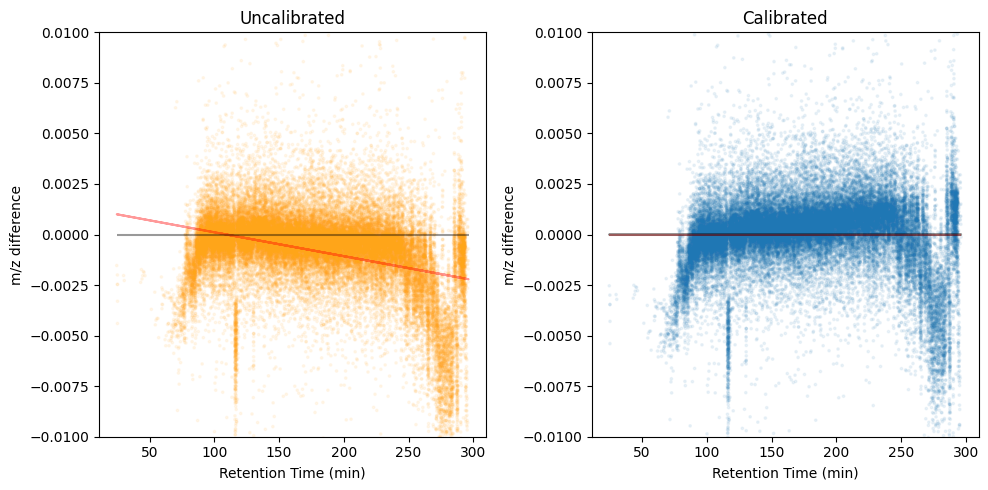

In [9]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# First subplot
axs[0].scatter(df2['rt'], df2['m/z_difference'], marker='o', linestyle='', alpha=0.075, s=3, color = "#FFA519")
x = df2['rt']
y = df2['m/z_difference']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
axs[0].plot(x, polynomial(x), color='red', alpha=0.4)

# Get the x-range of the data in the second subplot
x_range = df2['rt']

# Add horizontal line at y=0 with the same x-range as the data in the second subplot
axs[0].hlines(0, min(x_range), max(x_range), colors='black', alpha=0.4)

axs[0].set_ylim(-0.01, 0.01)
axs[0].set_xlabel('Retention Time (min)')
axs[0].set_ylabel('m/z difference')
axs[0].set_title('Uncalibrated')

# Second subplot
axs[1].scatter(df2['rt'], df2['adjusted_m/z_difference'], marker='o', linestyle='', alpha=0.075, s=3)
x = df2['rt']
y = df2['adjusted_m/z_difference']
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)

axs[1].hlines(0, min(x_range), max(x_range), colors='red', alpha=0.4)

axs[1].plot(x, polynomial(x), color='black', alpha=0.4)
axs[1].set_ylim(-0.01, 0.01)
axs[1].set_xlabel('Retention Time (min)')
axs[1].set_ylabel('m/z difference')
axs[1].set_title('Calibrated')

plt.tight_layout()
plt.show()

In [10]:
df2['adjusted_exp_m/z'] = df2['exp_m/z'] + df2['adjusted_m/z_difference']
df2.head(5)

/tmp/ipykernel_165415/3813262753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['adjusted_exp_m/z'] = df2['exp_m/z'] + df2['adjusted_m/z_difference']


,peptide,proteins,num_proteins,filename,scannr,rank,label,expmass,calcmass,charge,peptide_len,missed_cleavages,isotope_error,precursor_ppm,fragment_ppm,hyperscore,delta_next,delta_best,rt,aligned_rt,predicted_rt,delta_rt_model,matched_peaks,longest_b,longest_y,longest_y_pct,matched_intensity_pct,scored_candidates,poisson,sage_discriminant_score,posterior_error,spectrum_q,peptide_q,protein_q,ms1_intensity,ms2_intensity,exp_m/z,calc_m/z,m/z_difference,adjusted_m/z_difference,adjusted_exp_m/z
0,VSHVSTGGGASLELLEGK,tr|A0A140VJR3|A0A140VJR3_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=20762,1,1,1739.9047,1739.9056,2,18,0,0.0,0.561273,4.512378,80.898759,57.306250,0.0,106.39572,0.358235,0.444003,0.085768,28,7,15,0.833333,52.370990,27,-22.036961,3.051130,-324.0,0.000159,0.000292,0.001187,17372374.0,2015707.5,869.952350,869.952800,0.00045,0.000415,869.952765
1,HIADLAGNSEVILPVPAFNVINGGSHAGNK,tr|A0A2R8YEM5|A0A2R8YEM5_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=59286,1,1,3010.5667,3010.5623,4,30,0,0.0,1.459703,3.733232,91.211309,91.211309,0.0,206.77390,0.696208,0.741128,0.044919,29,12,17,0.566667,55.617220,23,-21.322521,2.981234,-324.0,0.000159,0.000292,0.001187,432567550.0,83529656.0,752.641675,752.640575,-0.00110,0.000051,752.641726
2,HIADLAGNSEVILPVPAFNVINGGSHAGNK,tr|A0A2R8YEM5|A0A2R8YEM5_HUMAN,1,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=59470,1,1,3010.5623,3010.5623,4,30,0,0.0,0.000000,3.123588,87.483751,87.483751,0.0,207.29668,0.697969,0.741128,0.043159,29,12,17,0.566667,48.368570,11,-16.460864,2.966786,-324.0,0.000159,0.000292,0.001187,95504160.0,13040154.0,752.640575,752.640575,0.00000,0.001157,752.641732
3,SADESGQALLAAGHYASDEVR,tr|A0A0D9SF54|A0A0D9SF54_HUMAN;tr|A0A0D9SFF6|A...,4,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=29517,1,1,2145.9910,2145.9927,2,21,0,0.0,0.796361,4.024200,81.779226,63.839595,0.0,128.34155,0.432126,0.390783,0.041344,29,11,14,0.666667,51.264275,10,-16.229365,2.950630,-324.0,0.000159,0.000292,0.001187,8474093.0,1180256.4,1072.995500,1072.996350,0.00085,0.001074,1072.996574
4,DLSAAGIGLLAAATQSLSMPASLGR,tr|A0A0R4J2E8|A0A0R4J2E8_HUMAN;tr|A0A1B0GX04|A...,2,20210120_HM_HEK_IAA_300minGr_R1.mzML,controllerType=0 controllerNumber=1 scan=87181,1,1,2370.2590,2370.2576,2,25,0,0.0,0.618010,4.127809,84.998809,54.519394,0.0,292.91214,0.986236,0.972109,0.014127,28,13,15,0.600000,59.573494,45,-22.521459,2.929744,-324.0,0.000163,0.000299,0.000913,47365012.0,22585296.0,1185.129500,1185.128800,-0.00070,0.001468,1185.130968


In [11]:
from psims.transform.mzml import MzMLTransformer, cvstr

def calibrate_ms2(spectrum):
    retention_time = spectrum['scanList']['scan'][0]['scan start time']
    mz_values = spectrum['m/z array']
        
    # Apply the calibration function to the m/z values
    calibrated_mz_values = mz_values + (retention_time * slope + intercept)
    
    # Replace the original m/z values with the calibrated ones
    spectrum['m/z array'] = calibrated_mz_values   
    return spectrum

with open("20210120_HM_HEK_IAA_300minGr_R1.mzML", 'rb') as in_stream, open("20210120_HM_HEK_IAA_300minGr_R1_Calibrated.mzML", 'wb') as out_stream:
    MzMLTransformer(in_stream, out_stream, calibrate_ms2).write()

Handled 0 spectra
Handled 1000 spectra
Handled 2000 spectra
Handled 3000 spectra
Handled 4000 spectra
Handled 5000 spectra
Handled 6000 spectra
Handled 7000 spectra
Handled 8000 spectra
Handled 9000 spectra
Handled 10000 spectra
Handled 11000 spectra
Handled 12000 spectra
Handled 13000 spectra
Handled 14000 spectra
Handled 15000 spectra
Handled 16000 spectra
Handled 17000 spectra
Handled 18000 spectra
Handled 19000 spectra
Handled 20000 spectra
Handled 21000 spectra
Handled 22000 spectra
Handled 23000 spectra
Handled 24000 spectra
Handled 25000 spectra
Handled 26000 spectra
Handled 27000 spectra
Handled 28000 spectra
Handled 29000 spectra
Handled 30000 spectra
Handled 31000 spectra
Handled 32000 spectra
Handled 33000 spectra
Handled 34000 spectra
Handled 35000 spectra
Handled 36000 spectra
Handled 37000 spectra
Handled 38000 spectra
Handled 39000 spectra
Handled 40000 spectra
Handled 41000 spectra
Handled 42000 spectra
Handled 43000 spectra
Handled 44000 spectra
Handled 45000 spectra
H